In [2]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -----------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# requirements:
# pip install pandas numpy scikit-learn lightgbm shap matplotlib joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
import lightgbm as lgb
import shap
import json
import warnings
warnings.filterwarnings("ignore")

# ---- USER SETTINGS ---------------------------------------------------------
DATA_PATH = "data.csv"        # <- change to your dataset path
TARGET_COL = "target"         # <- change to your target column name (0/1)
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_JOBS = -1
OUTPUT_DIR = "outputs"
# ---------------------------------------------------------------------------

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Load data
TARGET_COL = "default"

df = pd.read_csv("credit_risk_dataset_5mb.csv")

# check target exists
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset columns: {df.columns.tolist()}")

# 2) Identify feature types
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])




In [10]:
# Heuristic: treat object and category dtype as categorical, others numeric
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Found {len(num_cols)} numeric and {len(cat_cols)} categorical features.")


Found 20 numeric and 4 categorical features.


In [11]:
# 3) Train/test split (stratify if possible)
if len(np.unique(y)) == 2:
    stratify = y
else:
    stratify = None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE, stratify=stratify)

In [19]:
# 4) Preprocessing pipeline (simple but robust)
# Numeric: median imputation
num_imputer = SimpleImputer(strategy="median")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[num_cols]),  columns=num_cols, index=X_test.index)

# Categorical: fill missing with "MISSING" and ordinal encode (LightGBM handles categorical via 'categorical_feature' too)
X_train_cat = X_train[cat_cols].fillna("MISSING").astype(str).copy()
X_test_cat  = X_test[cat_cols].fillna("MISSING").astype(str).copy()

ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
feature_names = X.columns.tolist()
if len(cat_cols) > 0:
    X_train_cat_enc = pd.DataFrame(ord_enc.fit_transform(X_train_cat), columns=cat_cols, index=X_train.index)
    X_test_cat_enc  = pd.DataFrame(ord_enc.transform(X_test_cat), columns=cat_cols, index=X_test.index)
else:
    X_train_cat_enc = pd.DataFrame(index=X_train.index)
    X_test_cat_enc  = pd.DataFrame(index=X_test.index)

# Combine
X_train_proc = pd.concat([X_train_num, X_train_cat_enc], axis=1)
X_test_proc  = pd.concat([X_test_num,  X_test_cat_enc],  axis=1)

# Save preprocessing artifacts
joblib.dump(num_imputer, os.path.join(OUTPUT_DIR, "num_imputer.joblib"))
joblib.dump(ord_enc, os.path.join(OUTPUT_DIR, "ord_enc.joblib"))
print(f"Preprocessing saved to {OUTPUT_DIR}/")



Preprocessing saved to outputs/


In [20]:
# 5) Train & tune LightGBM (randomized search, small budget — adjust n_iter)
lgb_clf = lgb.LGBMClassifier(objective="binary", random_state=RANDOM_STATE, n_jobs=4)

param_dist = {
    "num_leaves": [15, 31, 50, 100],
    "max_depth": [-1, 5, 10, 20],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "n_estimators": [100, 300, 500, 1000],
    "min_child_samples": [5, 10, 20, 50],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [0, 0.01, 0.1],
}

rs = RandomizedSearchCV(lgb_clf, param_distributions=param_dist,
                        n_iter=40, scoring="roc_auc", n_jobs=N_JOBS,
                        cv=3, random_state=RANDOM_STATE, verbose=1)

rs.fit(X_train_proc, y_train)
best = rs.best_estimator_
print("Best params:", rs.best_params_)
joblib.dump(best, os.path.join(OUTPUT_DIR, "best_lgb_model.joblib"))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 13642, number of negative: 26358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341050 -> initscore=-0.658619
[LightGBM] [Info] Start training from score -0.658619
Best params: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 15, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


['outputs\\best_lgb_model.joblib']

In [21]:
# 6) Evaluate on test set
y_pred_proba = best.predict_proba(X_test_proc)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

metrics = {"auc": float(auc), "f1": float(f1), "accuracy": float(acc), "precision": float(prec), "recall": float(recall)}
print("Test metrics:", metrics)
with open(os.path.join(OUTPUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

Test metrics: {'auc': 0.6763280808476363, 'f1': 0.29820725841714035, 'accuracy': 0.679, 'precision': 0.5859106529209622, 'recall': 0.2}


In [22]:
# 7) Traditional model feature importance (gain)
if hasattr(best, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": X_train_proc.columns,
        "importance": best.feature_importances_
    }).sort_values("importance", ascending=False)
else:
    fi = pd.DataFrame({
        "feature": X_train_proc.columns,
        "importance": np.zeros(len(X_train_proc.columns))
    })
fi.to_csv(os.path.join(OUTPUT_DIR, "model_feature_importance.csv"), index=False)
print("Saved model feature importance.")


Saved model feature importance.


In [23]:
# 8) SHAP global explanations (TreeExplainer)
explainer = shap.TreeExplainer(best)
# shap may require the original feature matrix as a numpy array or DataFrame
shap_values = explainer.shap_values(X_test_proc)  # for binary classification returns list [shap_for_class0, shap_for_class1] or array
# Decision: shap_values for class 1 often is shap_values[1] if returned as list
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals = shap_values[1]
else:
    shap_vals = shap_values

# Global summary plot (beeswarm)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals, X_test_proc, show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary_beeswarm.png"), bbox_inches="tight")
plt.close()

# Global bar plot of mean(|SHAP|)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals, X_test_proc, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary_bar.png"), bbox_inches="tight")
plt.close()

# Save top 10 SHAP features by mean absolute contribution
mean_abs_shap = pd.DataFrame({
    "feature": X_test_proc.columns,
    "mean_abs_shap": np.mean(np.abs(shap_vals), axis=0)
}).sort_values("mean_abs_shap", ascending=False)
mean_abs_shap.head(20).to_csv(os.path.join(OUTPUT_DIR, "shap_mean_abs.csv"), index=False)
top10_shap = mean_abs_shap.head(10)
top10_shap.to_csv(os.path.join(OUTPUT_DIR, "shap_top10.csv"), index=False)
print("Saved SHAP global feature importances and plots.")


Saved SHAP global feature importances and plots.


In [24]:
# 9) Select 3-5 specific loan cases:
# - highest predicted probability (likely default)
# - lowest predicted probability (likely safe)
# - borderline (closest to 0.5)
n_local = 3
df_test = X_test_proc.copy()
df_test[TARGET_COL] = y_test
df_test["pred_proba"] = y_pred_proba
df_test = df_test.reset_index(drop=True)
high_idx = df_test["pred_proba"].idxmax()
low_idx = df_test["pred_proba"].idxmin()
border_idx = (df_test["pred_proba"] - 0.5).abs().idxmin()
selected_indices = list({int(high_idx), int(low_idx), int(border_idx)})


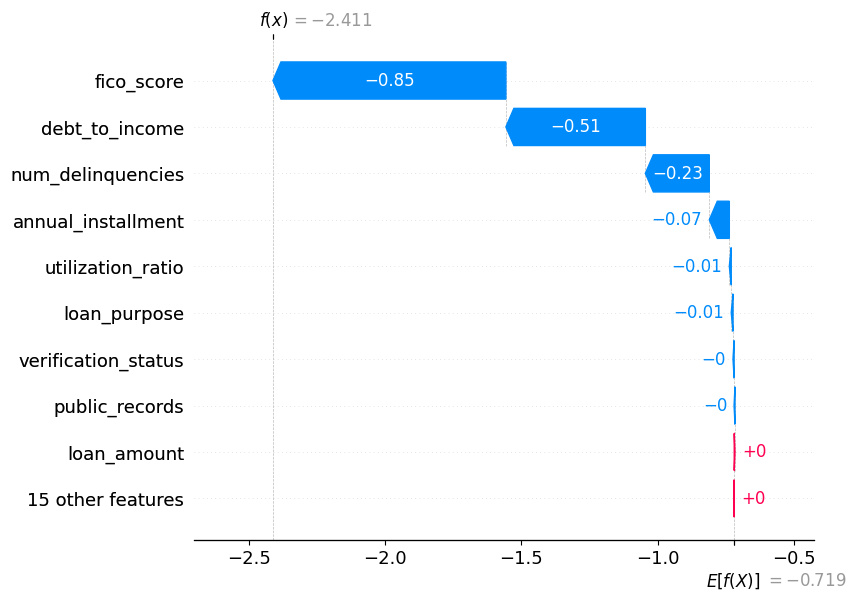

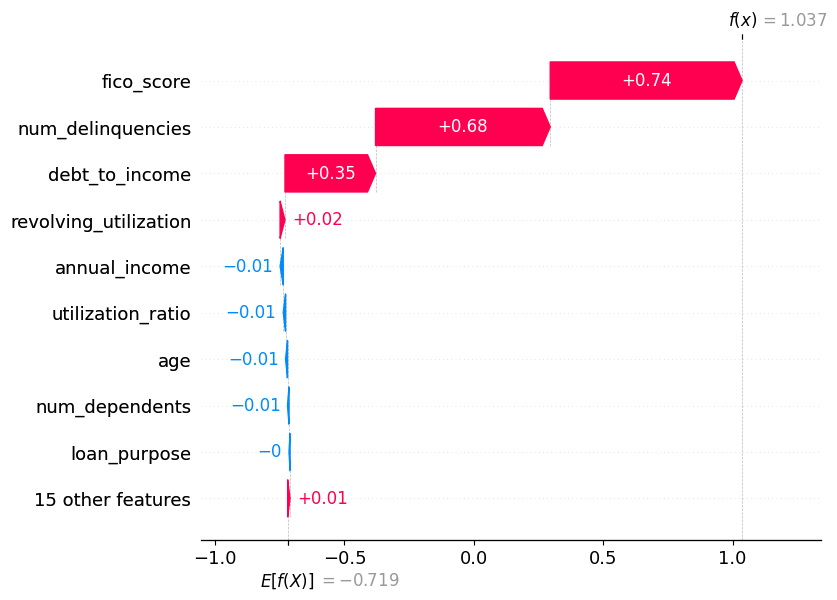

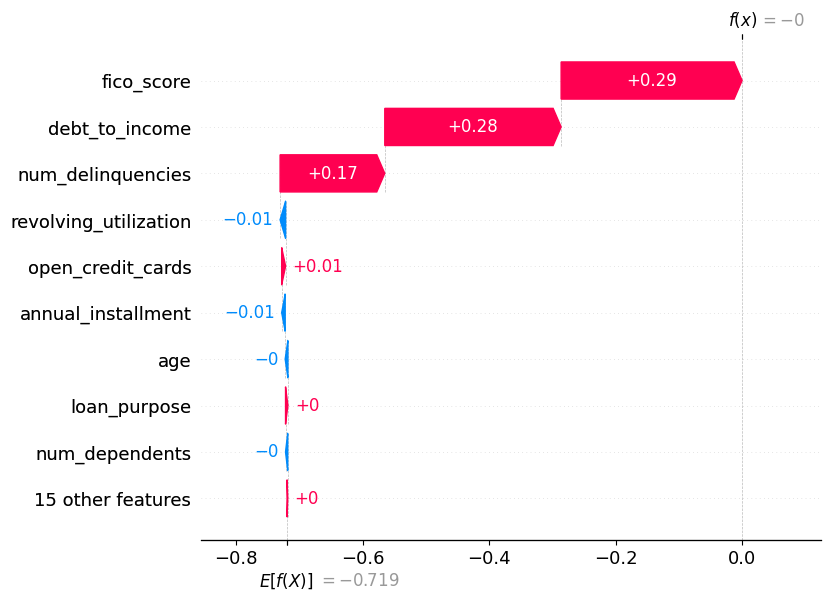

Local explanations saved for indices: [8634, 446, 8042]


In [26]:
# 10) Plot local explanations (waterfall) + automated textual description
def save_waterfall_and_text(i, shap_vals, X_df, feature_names, outdir=OUTPUT_DIR):
    sample = X_df.loc[i, X_train_proc.columns]  # features only
    sv = shap_vals[i]
    # Waterfall
    plt.figure(figsize=(6,4))
    try:
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, sv, feature_names=X_df.columns)  # fallback legacy
    except Exception:
        # newer shap waterfall
        shap.plots.waterfall((sv, explainer.expected_value), show=False)
    plt.title(f"Local SHAP waterfall for index {i} (pred={X_df.loc[i,'pred_proba']:.3f})")
    plt.tight_layout()
    # save
    fname = os.path.join(outdir, f"waterfall_index_{i}.png")
    plt.savefig(fname, bbox_inches="tight")
    plt.close()

    # Plain-language summary: top + and - contributors
    abs_contribs = pd.Series(sv, index=feature_names).abs().sort_values(ascending=False)
    top_feats = list(abs_contribs.head(8).index)
    contributions = pd.Series(sv, index=feature_names).loc[top_feats]
    pos = contributions[contributions > 0].sort_values(ascending=False)
    neg = contributions[contributions < 0].sort_values()
    text_lines = []
    text_lines.append(f"Case index {i}, predicted probability = {X_df.loc[i,'pred_proba']:.3f}.")
    if len(pos) > 0:
        text_lines.append("Top factors increasing predicted default risk (pushing prediction up):")
        for f, val in pos.items():
            text_lines.append(f" - {f}: increases risk by {val:.3f} (value = {sample[f]})")
    if len(neg) > 0:
        text_lines.append("Top factors decreasing predicted default risk (pushing prediction down):")
        for f, val in neg.items():
            text_lines.append(f" - {f}: decreases risk by {val:.3f} (value = {sample[f]})")
    # Fallback if none
    if len(pos) == 0 and len(neg) == 0:
        text_lines.append("No strong contributors found for this case.")
    text = "\n".join(text_lines)
    txtfile = os.path.join(outdir, f"local_explanation_index_{i}.txt")
    with open(txtfile, "w") as f:
        f.write(text)
    return fname, txtfile

saved_local_files = []
for idx in selected_indices:
    fname, txtfile = save_waterfall_and_text(idx, shap_vals, df_test, feature_names)
    saved_local_files.append((idx, fname, txtfile))

print("Local explanations saved for indices:", [s[0] for s in saved_local_files])

In [27]:
# 11) Export a quick report CSV summarizing top features and metrics
report = {
    "metrics": metrics,
    "top10_shap": top10_shap.set_index("feature")["mean_abs_shap"].to_dict(),
    "top10_model_importance": fi.head(10).set_index("feature")["importance"].to_dict()
}
with open(os.path.join(OUTPUT_DIR, "quick_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("Quick report saved to outputs/quick_report.json")
print("All done. Check the outputs/ folder.")

# Optional: print file list
print("\nSaved files:")
for root, dirs, files in os.walk(OUTPUT_DIR):
    for fn in files:
        print("-", os.path.join(root, fn))


Quick report saved to outputs/quick_report.json
All done. Check the outputs/ folder.

Saved files:
- outputs\best_lgb_model.joblib
- outputs\local_explanation_index_446.txt
- outputs\local_explanation_index_8042.txt
- outputs\local_explanation_index_8634.txt
- outputs\metrics.json
- outputs\model_feature_importance.csv
- outputs\num_imputer.joblib
- outputs\ord_enc.joblib
- outputs\quick_report.json
- outputs\shap_mean_abs.csv
- outputs\shap_summary_bar.png
- outputs\shap_summary_beeswarm.png
- outputs\shap_top10.csv
- outputs\waterfall_index_446.png
- outputs\waterfall_index_8042.png
- outputs\waterfall_index_8634.png
